Sentiment analysis is a natural language processing (NLP) technique that involves analyzing  text to determine the sentiment or emotion behind it.

NLP is used to process and analyze large amounts of text data to identify patterns, trends, and insights.

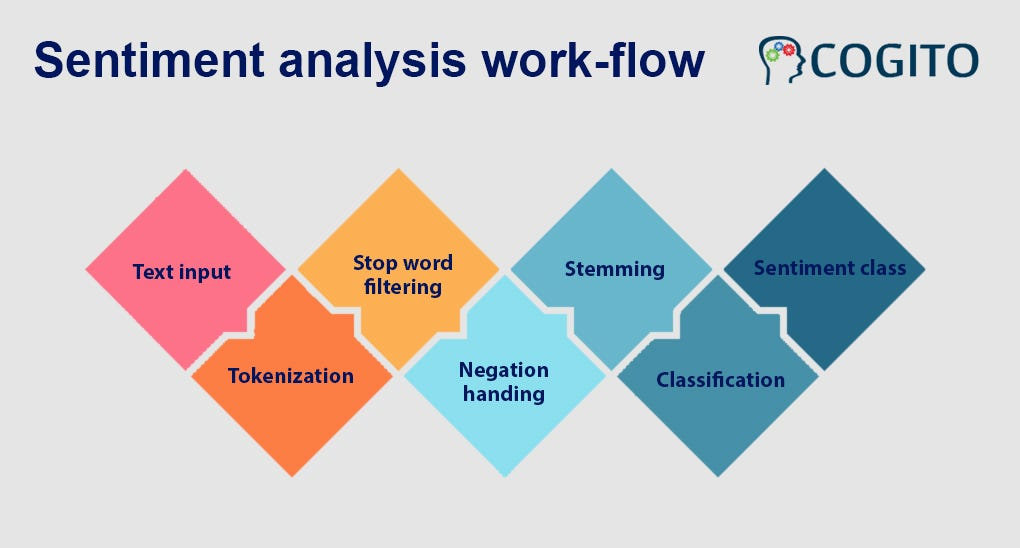

**Models used :**
1. CNN
2. LSTM
3. Bi-Directional LSTM

# IMPORTING DEPENDENCIES

In [1]:
import tensorflow
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,SpatialDropout1D,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,GlobalMaxPooling1D

import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **ARCHITECTURE**

1. Importing Dataset and encoding the label 
2. Preprocessing the text by removing stop words,punctuations,html tags,hash tags,numbers,emoticons,case folding and lemmatization
3. Tokenizing using Keras Tokenizer 
4. Converting text data to sequences of integers and padding subsequently
5. Model Building
6. Plotting the Accuracies and Losses
7. Evaluating Different Models using ROC-AUC curve

# Importing Dataset and encoding the label

##Dataset :
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
df = pd.read_csv("/content/drive/MyDrive/imdb.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Here there are about `50000 rows` and `2 columns`

Sentiment Column has labels as : `positive`and `negative`

We have to encode the labels as :   positive as `1`  and negative as `0`


In [4]:
mapping = dict(positive=1,
               negative=0)

# creating a mapping to encode the labels
df['sentiment'] = df['sentiment'].map(mapping)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
# Finding the value counts for each label
df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

The Distribution between each classes are equal in number,hence it is balanced dataset

In [6]:
# checking out if there is any null values in the dataset
df.isna().sum()

# no null values seems to be found

review       0
sentiment    0
dtype: int64

In [7]:
# converting the sentiment column of the dataframe to numpy array
label = df['sentiment']
label = label.to_numpy()
type(label)

numpy.ndarray

In [8]:
# downloading nltk dependencies
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
all_stopwords = stopwords.words('english')
negation = ['no','not']
all_stopwords = [w for w in all_stopwords if w not in negation]

def preprocessing(data):
    corpus = []
    for i in range(len(data)):
        # remove urls
        tweet = re.sub(r'http\S+', ' ', data[i]) # links

        # remove html tags
        tweet = re.sub(r'<.*?>', ' ', tweet) # tags        
        tweet = re.sub('&\w+([-.]\w+)*', ' ', tweet) # colorcodes

        # remove digits
        tweet = re.sub(r'\d+', ' ', tweet)
        tweet = re.sub('@\w+([-.]\w+)*', ' ', tweet) # mentions

        # remove emojis
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
        tweet = emoji_pattern.sub(r'', tweet) # no emoji

        # remove hashtags
        tweet = re.sub(r'#\w+', ' ', tweet) # hashtags
        review = re.sub('[^a-zA-Z]', ' ', tweet) # any characters other than alphabets
        review = review.lower() # casefolding
        review = review.split() 
        lemma= WordNetLemmatizer() # lemmatization
        review = [lemma.lemmatize(word) for word in review if word not in all_stopwords]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [10]:
review = preprocessing(df['review'])

# **Converting text data to sequences of integers and padding**

`train_test_split` with test size = 20% 

( ie trainset = 40000 samples and  testset = 10000 samples)

In [11]:
X_train, X_test,y_train,y_test = train_test_split(review,label,test_size=0.20,stratify = label,random_state=42)

In [12]:
token = Tokenizer()
token.fit_on_texts(X_train)

In [13]:
# Convert text data to sequences of integers
train_sequences = token.texts_to_sequences(X_train)
valid_sequences = token.texts_to_sequences(X_test)

In [14]:
vocab_size = len(token.word_index)+1
vocab_size

# there are 89657 unique words in the corpus 
# we will feed this to the input_dim of embedding layer
# +1 because the index starts from 0

81371

In [15]:
maxlen = 100 # specifies the maximum length of the sequences after padding or truncating.

X_train = pad_sequences(train_sequences, maxlen=maxlen,padding = 'post')
X_test = pad_sequences(valid_sequences, maxlen=maxlen,padding = 'post')


In [16]:
X_train.shape

(40000, 100)

# Explanation

*   The Keras Tokenizer is used to convert **raw text data into a sequence of integers** that can be used as input to a neural network for sentiment analysis .

*   **Fitting the tokenizer** on the input data and calling the `fit_on_texts()` method. The tokenizer will then analyze the text data and build a vocabulary of words, assigning each word a unique integer index.


*  `texts_to_sequences()` is used where each sublist represents a sequence of integers corresponding to the words in the input text

*   **Padding** : Since neural networks require inputs of a fixed length, the sequences of integers returned by the tokenizer will depend the length of the comment.Padding is the process of **adding zeros or other specified values to the beginning or end of the sequences until they reach a predefined length.** This ensures that all sequences have the same length and can be fed into the model for processing


*   `maxlen = 100 ` specifies the maximum length of the sequences after padding or truncating.

*   If a sequence is shorter than  `maxlen`, it will be padded with zeros at the end to reach the desired length.
    
    If a sequence is longer than `maxlen`, it will be truncated to the first `maxlen` elements.

*   `X_train` and  `X_test` is a Sequence of Token Indexes not the actual vector that  represents the sentences

*   The word Vector will always will be in the range of -1 and +1 and that will be projected inside ML model automatically to train the model
our next task is to convert the sequence of token indices to vector representation using Embedding Layer





In [17]:
# our next task is to convert the sequence of token indices to vector representation 

Another popular approach to text classification is the use of deep learning models, such as **convolutional neural networks (CNNs) and recurrent neural networks (RNNs)**. These models can *Capture the contextual information* in the text and learn more complex features than the bag-of-words model. However, they require more training data and computational resources.

# Building Convolutional Neural Network Model

In [18]:
vec_size = 200


cnn = Sequential()
cnn.add(Embedding(input_dim = vocab_size, output_dim = vec_size,
                    input_length=maxlen,trainable=False))

cnn.add(Conv1D(32,8,activation = 'relu'))
cnn.add(MaxPooling1D(2))
cnn.add(Dropout(0.5))

cnn.add(Dense(32,activation = 'relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(16,activation = 'relu'))

cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation='sigmoid'))



# Model  Explanation


**1. Adding Embedding Layer**

Its purpose is to convert high-dimensional sparse data, such as words in a text document, into a lower-dimensional dense representation that captures semantic meaning of each word based on its context and co-occurrence with other words in the text


 The Embedding layer takes as input a 2D tensor of integer indices, where each integer corresponds to a unique word or character in the vocabulary

*    ```input_dim```: the size of the vocabulary, 
*   ```output_dim```: the size of the dense vector representation of each word or character, often referred to as the embedding dimension.

*   ```input_length```: the length of the input sequences, i.e., the number of words or characters in each sequence


*   the ``` trainable``` argument in the Embedding layer is used to specify whether the weights of the layer should be updated during training or kept fixed.




**2. Conv1D**

1D convolution layer (e.g. temporal convolution).

During training, the filters in the Conv1D layer learn to detect specific patterns or features in the embeddings, such as n-grams, word clusters, or syntactic structures. These features are combined to produce a feature map for each filter, which represents the presence or absence of the feature at each position in the input sequence.


**3. Maxpooling**

MaxPooling1D reduces the dimensionality of the output of a Conv1D layer by taking the maximum value of a window of activations. This helps to reduce the number of parameters in the network, which can prevent overfitting and improve the generalization performance of the model.


**3. DropOut**

Dropout is a regularization technique used in deep learning to prevent overfitting and improve model generalization. It is a simple yet effective technique that randomly drops out, or "turns off," some of the neurons in a neural network during training.



**4.Dense Layers**
Dense layers and CNNs (Convolutional Neural Networks) are both commonly used in deep learning for different purposes.

Dense layers, also known as fully connected layers, are a type of neural network layer where each neuron is connected to every neuron in the previous layer. The purpose of dense layers is to learn complex nonlinear relationships between input features and the target variable. 

**5.GlobalMaxPooling1D**

GlobalMaxPooling1D,is a global pooling operation that selects the maximum value from each feature map across the entire input sequence and  to reduce the temporal dimensionality of the feature maps, while still preserving the most important features.

**6. Output Layer**

`cnn.add(Dense(1,activation='sigmoid'))`

The `1` parameter in the `Dense(1)` argument specifies the number of output neurons in the layer. Since this is a binary classification problem, only one output neuron is needed to output the predicted probability of the positive class.

The `sigmoid` activation function is applied to the output of the layer to ensure that the predicted probability value falls between 0 and 1

In [19]:
cnn.compile(optimizer = 'adam',loss = 'binary_crossentropy' ,metrics = ['accuracy'])

 The compilation is the final step in creating a model. Once the compilation is done, we can move on to training phase.It is used to configure the learning process of a neural network model.



*  `optimizer`:  specifies the optimization algorithm to use during training. In this example, the Adam[Adaptive Moment Estimation] optimizer is used.

*   `loss` : specifies the loss function to minimize during training.Here `'binary_crossentropy'` is used for Binary Classification (positive and negative sentiment) 

*   'metrics` : specifies the evaluation metrics to use during training and testing.


In [20]:
cnn_history = cnn.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test))

Epoch 1/15
1250/1250 [==============================] - 21s 5ms/step - loss: 0.6375 - accuracy: 0.6194 - val_loss: 0.5945 - val_accuracy: 0.6927
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5580 - accuracy: 0.7107 - val_loss: 0.5673 - val_accuracy: 0.7198
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5183 - accuracy: 0.7406 - val_loss: 0.5602 - val_accuracy: 0.7101
Epoch 4/15
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4880 - accuracy: 0.7618 - val_loss: 0.5552 - val_accuracy: 0.7075
Epoch 5/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4626 - accuracy: 0.7784 - val_loss: 0.5680 - val_accuracy: 0.6867
Epoch 6/15
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4326 - accuracy: 0.7991 - val_loss: 0.5327 - val_accuracy: 0.7271
Epoch 7/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4135 - accuracy: 0.8114 - val_loss: 0.5414 - val_accuracy

In [ ]:
import pickle
with open ("cnn_sentiment_analysis.pkl",'wb') as f:
    pickle.dump(cnn,f)

In [22]:
score = cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5055 - accuracy: 0.7591


In [73]:
print("Test loss :",score[0])
print("Test Accuracy :",score[1])

Test loss : 0.5055009722709656
Test Accuracy : 0.7591000199317932


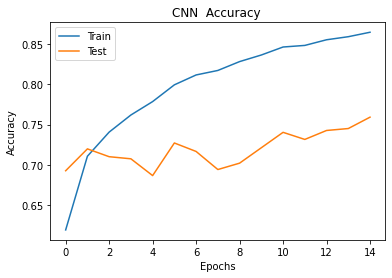

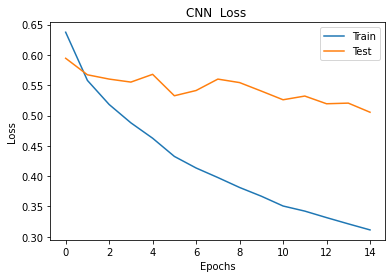

In [74]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title("CNN  Accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title("CNN  Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()



Here `CNN` really serves as Baseline Model we can go forward to advanced model like`RNN` which is suitable  for capturing the sequential data

#  Building  LSTM  Model

**RNNs are generally preferred over CNNs for sentiment analysis** tasks because they are better suited for handling sequential data, capturing long-term dependencies, capturing word-level features, and providing interpretable predictions.

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network (RNN) architecture that has been successfully applied to a sentiment analysis. LSTMs are particularly useful when dealing with sequential data.

Structure of an LSTM consists of a cell state and three gates: 



1.   Input gate
2.   Forget gate
3.   Output gate


*   The input gate determines which information from the input sequence should be added to the cell state. 

*   The forget gate determines which information from the previous cell state should be forgotten or retained. 

*   The output gate determines which information from the cell state should be output as the final prediction.


In [82]:
from keras.layers import LSTM

In [86]:
vec_size = 300
lstm =Sequential()
# Embedding layer
lstm.add(Embedding(input_dim = vocab_size, output_dim = vec_size,input_length=maxlen,trainable = False))
#lstm
lstm.add(LSTM(200,dropout=0.20))
lstm.add(Dense(1,activation='sigmoid'))

# Explanation:


*   `vec_size = 300` specifies the dimensionality of the word embeddings that will be used as input to the LSTM layer.

*   Embedding Layer as like in CNN

*   `LSTM(100)`  adds an LSTM layer with 100 hidden units to the model.

*   `dropout=0.20`  means that 20% of the LSTM outputs will be randomly set to 0 during training to prevent overfitting.


*   Output Layer as like in CNN



In [87]:
lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [88]:
lstm_history = lstm.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test))

Epoch 1/15
1250/1250 [==============================] - 80s 9ms/step - loss: 0.6920 - accuracy: 0.5270 - val_loss: 0.6882 - val_accuracy: 0.5404
Epoch 2/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6878 - accuracy: 0.5440 - val_loss: 0.6907 - val_accuracy: 0.5196
Epoch 3/15
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6813 - accuracy: 0.5444 - val_loss: 0.6713 - val_accuracy: 0.5669
Epoch 4/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6474 - accuracy: 0.6273 - val_loss: 0.6748 - val_accuracy: 0.5708
Epoch 5/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6764 - accuracy: 0.5648 - val_loss: 0.6472 - val_accuracy: 0.6244
Epoch 6/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6297 - accuracy: 0.6548 - val_loss: 0.6007 - val_accuracy: 0.7001
Epoch 7/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5597 - accuracy: 0.7174 - val_loss: 0.5124 - val_ac

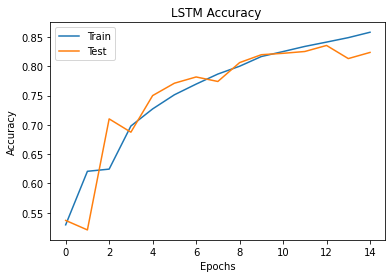

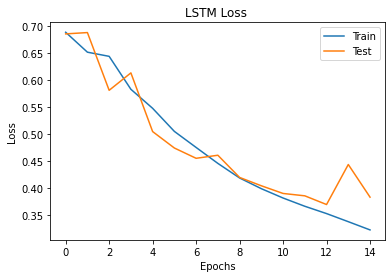

In [29]:
import matplotlib.pyplot as plt
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title("LSTM Accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title("LSTM Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()



In [ ]:
import pickle
with open ("lstm_sentiment_analysis.pkl",'wb') as f:
    pickle.dump(lstm,f)

In [89]:
score_lstm = lstm.evaluate(X_test,y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4134 - accuracy: 0.8168


In [90]:
print("Test loss :",score_lstm[0])
print("Test Accuracy :",score_lstm[1])

Test loss : 0.4134449362754822
Test Accuracy : 0.8167999982833862


# Bidirectional LSTM

**Bidirectional Long Short-Term Memory (Bi-LSTM)** is a type of recurrent neural network (RNN) that extends the basic LSTM model by processing the input sequence in **both forward and backward directions.**



*   In a standard LSTM model, the network processes the input sequence in one direction only, from the first element to the last. However, in some applications, the context of the input sequence may depend on both the past and future elements of the sequence.

*   Bi-LSTM addresses this problem by processing the input sequence in both directions, using two separate LSTM layers. The output of each LSTM layer is then combined to produce the final output.



In [33]:
vec_size = 200
bi_lstm =Sequential()
# Embedding layer
bi_lstm.add(Embedding(input_dim = vocab_size, output_dim = vec_size,input_length=maxlen,trainable = False))
#lstm
bi_lstm.add(Bidirectional(LSTM(200, dropout=0.4, recurrent_dropout=0.4)))
bi_lstm.add(Dense(1,activation='sigmoid'))


In [34]:
bi_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [35]:
bi_lstm_history = bi_lstm.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test))

Epoch 1/30
1250/1250 [==============================] - 390s 308ms/step - loss: 0.6866 - accuracy: 0.5566 - val_loss: 0.6198 - val_accuracy: 0.6545
Epoch 2/30
1250/1250 [==============================] - 425s 340ms/step - loss: 0.6262 - accuracy: 0.6556 - val_loss: 0.6104 - val_accuracy: 0.6838
Epoch 3/30
1250/1250 [==============================] - 395s 316ms/step - loss: 0.6015 - accuracy: 0.6788 - val_loss: 0.5818 - val_accuracy: 0.6996
Epoch 4/30
1250/1250 [==============================] - 381s 305ms/step - loss: 0.5794 - accuracy: 0.6936 - val_loss: 0.5640 - val_accuracy: 0.7254
Epoch 5/30
1250/1250 [==============================] - 385s 308ms/step - loss: 0.5556 - accuracy: 0.7150 - val_loss: 0.5089 - val_accuracy: 0.7563
Epoch 6/30
1250/1250 [==============================] - 386s 308ms/step - loss: 0.5378 - accuracy: 0.7280 - val_loss: 0.4951 - val_accuracy: 0.7616
Epoch 7/30
1250/1250 [==============================] - 380s 304ms/step - loss: 0.5191 - accuracy: 0.7416 - val_

In [ ]:
with open ("bi_lstm.pkl",'wb') as f:
    pickle.dump(bi_lstm,f)

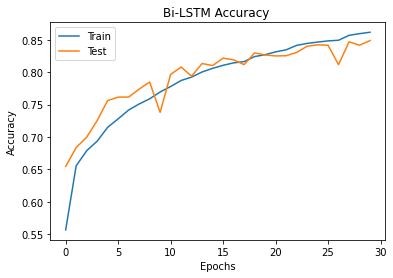

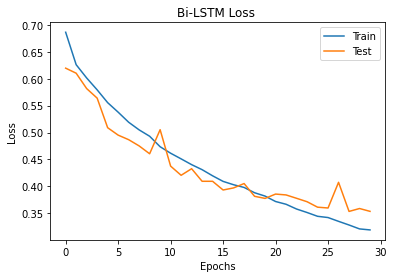

In [39]:

plt.plot(bi_lstm_history.history['accuracy'])
plt.plot(bi_lstm_history.history['val_accuracy'])
plt.title("Bi-LSTM Accuracy ")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()


plt.plot(bi_lstm_history.history['loss'])
plt.plot(bi_lstm_history.history['val_loss'])
plt.title("Bi-LSTM Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train','Test'],loc='best')
plt.show()



In [94]:
score_bilstm = bi_lstm.evaluate(X_test,y_test)

313/313 [==============================] - 18s 59ms/step - loss: 0.3532 - accuracy: 0.8489


In [95]:
print("Test Loss :",score_bilstm[0])
print("Test Accuracy :",score_bilstm[1])

Test Loss : 0.35324400663375854
Test Accuracy : 0.8489000201225281


# ROC AUC

In [63]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [ ]:
pred_prob_cnn = cnn.predict(X_test).ravel()
pred_prob_lstm = lstm.predict(X_test).ravel()
pred_prob_bilstm = bi_lstm.predict(X_test).ravel()


fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_prob_cnn , pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,pred_prob_lstm , pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(y_test,pred_prob_bilstm , pos_label=1)

auc1 = auc(fpr1,tpr1)
auc2 = auc(fpr2,tpr2)
auc3 = auc(fpr3,tpr3)


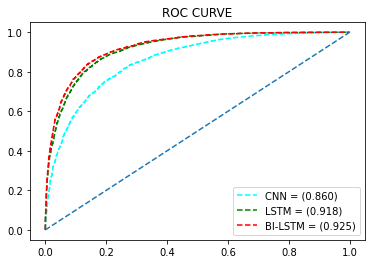

In [99]:
plt.plot(fpr1,tpr1,linestyle='--',color='cyan',label='CNN = (%.3f)'%auc1)
plt.plot(fpr2,tpr2,linestyle='--',color='green',label='LSTM = (%.3f)'%auc2)
plt.plot(fpr3, tpr3,linestyle='--',color='red',label='BI-LSTM = (%.3f)'%auc3)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC CURVE")
plt.legend()